# Self-Organizing Maps (SOMs) Figure Notebook
- **Make map of SOM training area**
- Notebook by Alice DuVivier (NCAR)
- November 2022

In [1]:
# Needed imports

from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import cmocean

import utils

### Set user-specified information

In [2]:
# set: variable to test, the location of the already extracted training data
var_in = 'aice_d'
sector_short = 'Ross'
mask_in = 'Ross_mask'
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/'+sector_short+'_analysis_v3/'
path_out = path_in+'figures_outline/'

In [3]:
# Set plotting limits
lat_max = -72
lat_min = -85
lon_max = 200
lon_min = 160
lon_avg = 190

### Create mask for training points only

In [4]:
# Load in the masking file
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/antarctic_ocean_masks_3.nc')


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sh_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'socn_mask' has multiple fill values {0, -2147483647}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Wed_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Ross_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  de

In [5]:
ds_masks_training = ds_masks.where((ds_masks['lat2d_T']<lat_max) & (ds_masks['lat2d_T']>lat_min) & \
                        (ds_masks['lon2d_T']>lon_min) & (ds_masks['lon2d_T']<lon_max), drop=True) 

In [6]:
ds_masks_training

<xarray.Dataset>
Dimensions:     (nlat: 14, nlon: 35)
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    sh_mask     (nlat, nlon) float32 dask.array<chunksize=(14, 35), meta=np.ndarray>
    socn_mask   (nlat, nlon) float64 dask.array<chunksize=(14, 35), meta=np.ndarray>
    Wed_mask    (nlat, nlon) float32 dask.array<chunksize=(14, 35), meta=np.ndarray>
    Ross_mask   (nlat, nlon) float32 dask.array<chunksize=(14, 35), meta=np.ndarray>
    Ind_mask    (nlat, nlon) float32 dask.array<chunksize=(14, 35), meta=np.ndarray>
    Pac_mask    (nlat, nlon) float32 dask.array<chunksize=(14, 35), meta=np.ndarray>
    ...          ...
    coast_mask  (nlat, nlon) float32 dask.array<chunksize=(14, 35), meta=np.ndarray>
    lon2d_T     (nlat, nlon) float64 dask.array<chunksize=(14, 35), meta=np.ndarray>
    lat2d_T     (nlat, nlon) float64 dask.array<chunksize=(14, 35), meta=np.ndarray>
    lon2d_U     (nlat, nlon) float64 dask.array<chunksize=(14, 35), meta=np.ndarray>
    lat2d_U     (nlat, nlon) float64 dask.array<chunksize=(14, 35), meta=np.ndarray>
    tarea       (nlat, nlon) float64 dask.array<chunksize=(14, 35), meta=np.ndarray>

In [7]:
# need to use the intersection of masks for a particular sector (e.g. Ross_mask) with the coastal mask (coast_mask)
# create array for mask
ds_training = xr.where((ds_masks_training[mask_in]==1)&(ds_masks_training['coast_mask']==1),ds_masks_training['coast_mask'],0)

In [8]:
ds_training

<xarray.DataArray (nlat: 14, nlon: 35)>
dask.array<where, shape=(14, 35), dtype=float32, chunksize=(14, 35), chunktype=numpy.ndarray>
Dimensions without coordinates: nlat, nlon

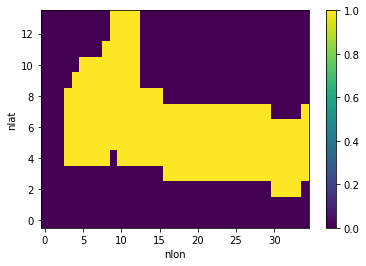

In [9]:
ds_training.plot()

### Create land mask for coloring

In [10]:
# file name for training variable only here 
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'
fin_mask = 'antarctic_data_for_som_composites_aice_d'
ds_mask = xr.open_mfdataset(data_path_in+fin_mask+'.nc')

In [11]:
mask = ds_mask["data"].isel(training_times=0)
mask.load()

<xarray.DataArray 'data' (nj: 36, ni: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.9999942 , 0.9999906 , 0.99997586, ...,        nan,        nan,
               nan],
       ...,
       [0.89653015, 0.89080995, 0.8772375 , ..., 0.8732328 , 0.88580495,
        0.8947713 ],
       [0.610462  , 0.5715022 , 0.4983742 , ..., 0.5884182 , 0.59032935,
        0.609117  ],
       [0.16595681, 0.13268058, 0.09189054, ..., 0.18806624, 0.17819193,
        0.17767288]], dtype=float32)
Coordinates:
    time       object 1980-07-01 00:00:00
    member_id  <U11 'r1i1001p1f1'
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

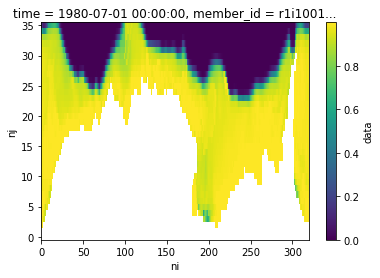

In [12]:
mask.plot()

In [13]:
# turn it into a binary mask (0 and 1)
mask_land = mask.where(mask>0.0,0)
mask_land = mask_land.where(mask_land==0, 1)

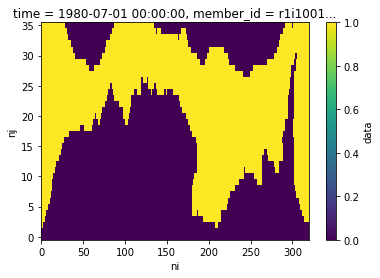

In [14]:
mask_land.plot()

In [15]:
# keep only ocean points
mask_land = mask_land.where(mask_land == 1)

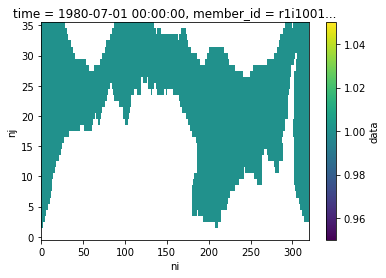

In [16]:
mask_land.plot()

### Make figure

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


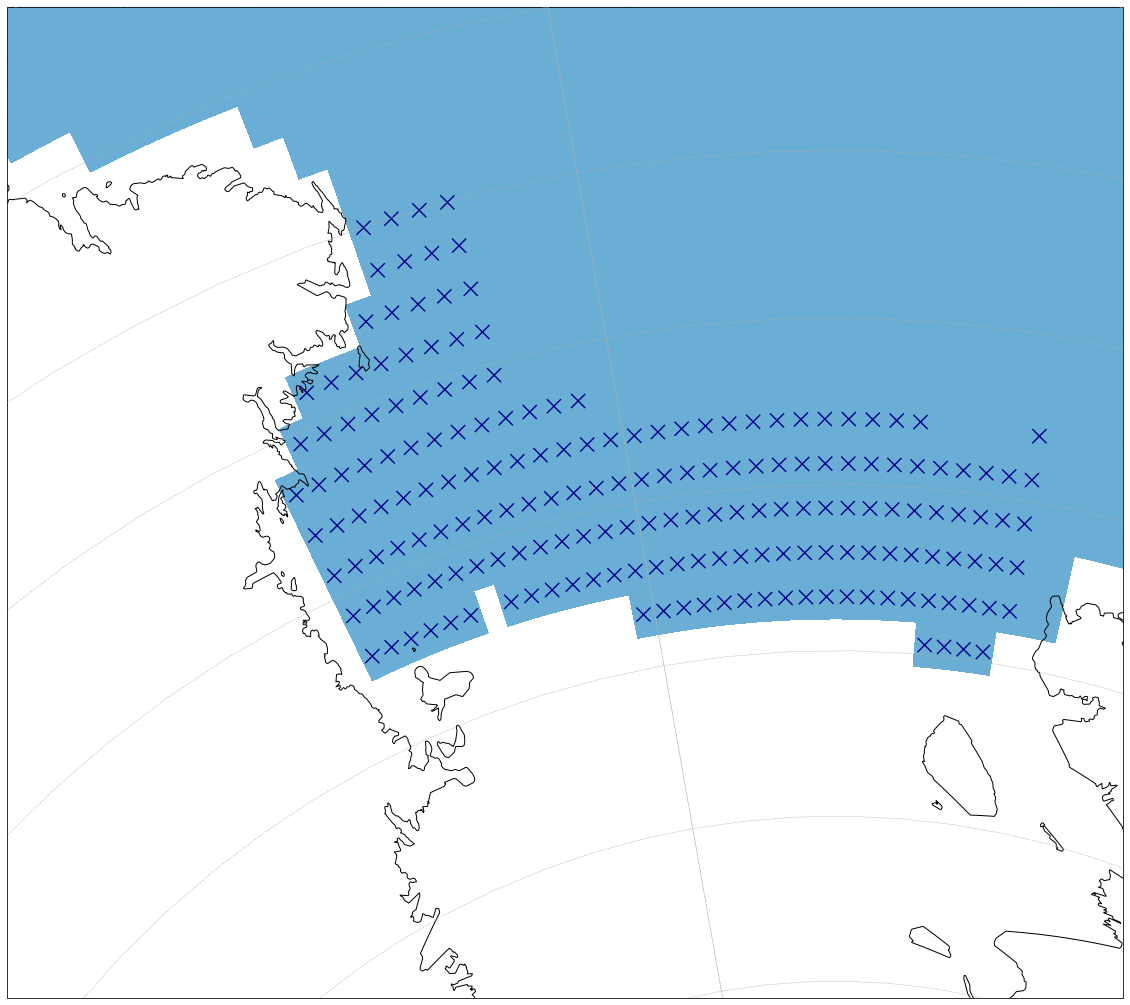

In [21]:
# create figure
fig = plt.figure(figsize=(20,20))
fout = path_out+'fig3'

### Shade ocean domain only
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# fix variable
lon, lat, field = utils.adjust_pop_grid(mask_land.TLON, mask_land.TLAT, mask_land)
this = ax.pcolor(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   cmap = 'Blues',
                   vmin=0.5,vmax=1.5)
### Add training points
this = ax.scatter(ds_masks_training.lon2d_U,ds_masks_training.lat2d_U,
                  ds_training,
                  transform=ccrs.PlateCarree(),
                  c = 'DarkBlue', marker='x', linewidths=20, alpha=1)

# set final plot details
ax.set_extent([lon_min,lon_max,lat_min+4,lat_max+2])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')    
ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)